# Tutorial 4: Pipeline

## Overview

In this tutorial, we will talk about the following:

* Loading data into Pipeline
    * Using tf.data.Dataset
    * Using torch.Dataloader
    * Using FastEstimator dataset
* Getting results in Pipeline
* How to use Numpy operators in Pipeline
    * Basic concepts about operators
    * Univariate and Multivariate Numpy operators
    * Customized Numpy operators
    * Load Numpy operators into Pipeline and visualize results

In deep learning, data preprocessing is a way of converting data from the raw form to a much more usable or desired form. It is one crucial step in the model training as it directly affects the ability of model to learn. <br>
`Pipeline` API operates by enabling such tasks in efficient manner. It takes care of extracting data from the disk and preprocessing before feeding it to the model. `Pipeline` operations usually happen on CPU.

## Loading data in Pipeline

In tutorial 2, we demonstrated the different types of datasets. We will see how datasets can be loaded in the `Pipeline` and various operations can be applied to the data. `fe.Pipeline` handles three different type of datasets,
* tf.data.Dataset
* torch.data.Dataloader
* fe.dataset

Let's create a sample datasets `tf.data.Dataset` and `torch.data.Dataloader` from numpy array and we will load them into `Pipeline`<br>

In [1]:
import numpy as np

# sample numpy array to later create datasets from them
x_train, y_train = (np.random.sample((100, 2)), np.random.sample((100, 1)))
train_data = {"x": x_train, "y": y_train}

### Using tf.data.Dataset

In [2]:
import fastestimator as fe
import tensorflow as tf

# create tf.data.Datasets from sample data
dataset_tf = tf.data.Dataset.from_tensor_slices(train_data)
dataset_tf = dataset_tf.batch(4)

# load data into pipeline
pipeline_tf = fe.Pipeline(dataset_tf)

### Using torch.data.Dataloader

We will create custom dataset class to load our train data into torch dataloader.

In [3]:
from torch.utils.data import Dataset

class TorchCustomDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    def __len__(self):
        return self.data["x"].shape[0]
    def __getitem__(self, idx):
        return {key: self.data[key][idx] for key in self.data}

In [4]:
import torch
from torch.utils import data

# create torch.data.Dataloader from sample data
dataset_torch = TorchCustomDataset(train_data)
dataloader_torch = data.DataLoader(dataset_torch, batch_size=4)

# load dataloader instance into pipeline
pipeline_torch = fe.Pipeline(dataloader_torch)

### Using FastEstimator Dataset

Next, we will see how to use one of the Fastestimator Dataset in the `Pipeline`. We will create `fe.dataset.NumpyDataset` and load it into pipeline. As we saw in tutorial 2, `NumpyDataset` takes dictionary with keys for <b>Input data</b> and <b>Ground truth label</b>.

In [5]:
from fastestimator.dataset.numpy_dataset import NumpyDataset

# create NumpyDataset from the sample data
dataset_fe = NumpyDataset(train_data)

pipeline_fe = fe.Pipeline(train_data=dataset_fe, batch_size=1)

## Getting results in Pipeline

After loading the data or performing preprocessing tasks, you might want to inspect the data in the `Pipeline` and ensure the output of the `Pipeline` is as you expected. `fe.Pipeline.get_results` provides this feature and is built to access such data in the `Pipeline`.

In [6]:
pipeline_tf.get_results(num_steps=1)

{'x': <tf.Tensor: shape=(4, 2), dtype=float64, numpy=
 array([[0.53428703, 0.69525494],
        [0.92603312, 0.24693308],
        [0.34052838, 0.63157394],
        [0.63737816, 0.25101075]])>,
 'y': <tf.Tensor: shape=(4, 1), dtype=float64, numpy=
 array([[0.29718931],
        [0.26778784],
        [0.16523936],
        [0.42751092]])>}

## How to use Numpy operators in Pipeline

In tutorial 3, we learned about the `Operators` and their structures. They are used in FastEstimator for constructing workflow graphs. Here we will talk about Numpy Operator (NumpyOp) and how to use them in `Pipeline`.

`NumpyOp` is the building block of the `Pipeline` and inherits base class `Op`. It performs preprocessing and augmentation tasks on non-Tensor data. With the list of `NumpyOp`, preprocessing tasks become considerably easier in just few lines of code. Many of the augmentation operations leverages the image augmentation library [albumentations](https://github.com/albumentations-team/albumentations). <br>
`NumpyOp` can be further classified in three main classes:
   * Univariate NumpyOp
   * Multivariate NumpyOp
   * Meta NumpyOp
   
In addition to that, we can customize the `NumpyOp` to perform our own operations on the data. Inheriting `fe.op.numpyop` we can create custom `NumpyOp` and use it in `Pipeline`.<br>
In this tutorial, we will learn about Univariate, Multivariate and Custom numpy operators. We will discuss Meta NumpyOp in the advanced tutorial of the `Pipeline`.

To demonstrate use of operators, we will first load Fashion MNIST dataset in the Pipeline and then will define list of numpy operators for preprocessing data. We will then visualize `Pipeline` Inputs and Outputs.

In [7]:
from fastestimator.dataset.data import mnist

mnist_train, mnist_eval = mnist.load_data()

### Univariate NumpyOp

Univariate numpy operators perform the same operation for all features. It takes single/multiple input(s) and return single/multiple output(s). For example, `Minmax` is an univariate numpy operator, no matter what feature it is it will perform<br>
data = (data - min) / (max - min)<br>

In [8]:
from fastestimator.op.numpyop.univariate import Minmax

minmax_op = Minmax(inputs="x", outputs="x_out")

### Multivariate NumpyOp

Multivariate numpy operators perform different operations based on the nature of features. For example, bounding box and mask of the same input image require different operations.

We will define Rotate numpy operator that will rotate the images 180 degrees.

In [9]:
from fastestimator.op.numpyop.multivariate import Rotate

rotation_op = Rotate(image_in="x_out", image_out="x_out", limit=180)

### Custom NumpyOp

Let's create custom Numpy operator that add random noise to the input images.

In [10]:
from fastestimator.op.numpyop import NumpyOp

class AddRandomNoise(NumpyOp):
    def forward(self, data, state):
        # generate noise array with 0 mean and 0.1 standard deviation
        noise = np.random.normal(0, 0.1, data.shape)
        data = data + noise
        return data
    
random_noise_op = AddRandomNoise(inputs="x_out", outputs="x_out")

### Putting them all together

Now, We will add the list of operaters, that we defined earlier, in the `Pipeline`. 

In [11]:
pipeline = fe.Pipeline(train_data=mnist_train,
                       eval_data=mnist_eval,
                       ops=[minmax_op, rotation_op, random_noise_op],
                      batch_size=2)

Let's get the `Pipeline` results and visualize the input and output images

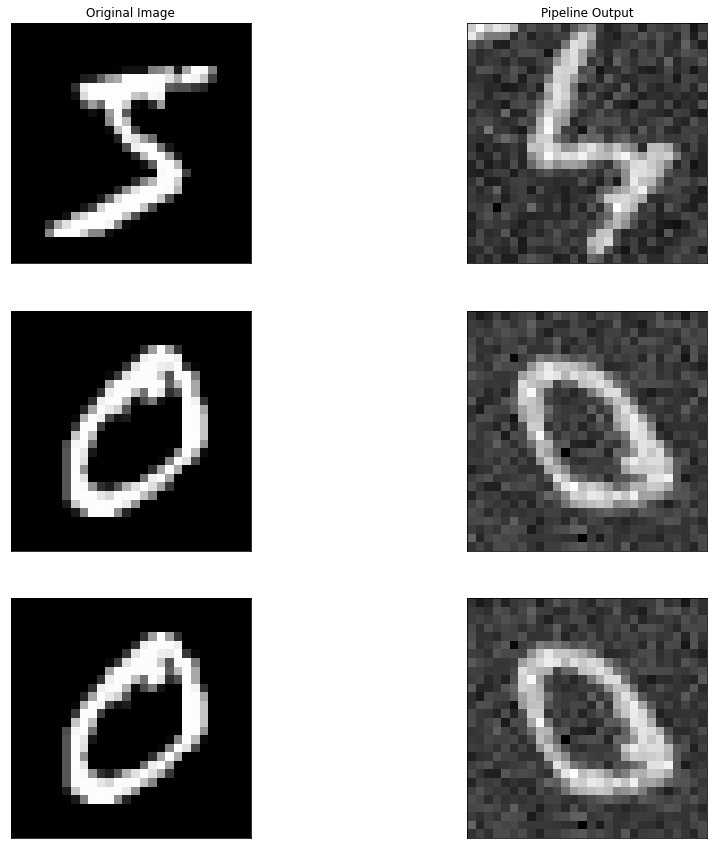

In [12]:
import matplotlib.pyplot as plt

sample_num = 3

# get the pipeline results
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]

# define subplots 
fig, axs = plt.subplots(sample_num, 2, figsize=(15,15))

axs[0,0].set_title("Original Image")
axs[0,1].set_title("Pipeline Output")

plt.setp(axs, xticks=[], yticks=[])

# iterate over sample to plot the results
for i, j in enumerate(np.random.randint(low=0, high=2, size=sample_num)):
    img_in = data_xin.numpy()[j]
    axs[i,0].imshow(img_in, cmap="gray")
    
    img_out = data_xout.numpy()[j]
    axs[i,1].imshow(img_out, cmap="gray")